#  Set up

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold
import lightgbm as lgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import _pickle as pickle
import gzip

In [2]:
df = pd.read_csv('new_extracted_data.csv')
df.tail()

,domainlength,www,subdomain,https,http,short_url,ip,@,-,=,...,pcextlinks,pcrequrl,zerolink,extfavicon,submit2email,sfh,redirection,domainage,domainend,label
69995,22,0,1,0,0,0,0,0,0,0,...,9.958506,1.724138,0,0,0,0.0,0,1,1,0
69996,17,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0,0,0,0.0,0,0,0,0
69997,16,1,0,0,0,0,0,0,0,0,...,33.333333,60.000000,0,0,0,0.0,0,0,1,0
69998,15,1,0,0,0,0,0,0,0,0,...,8.333333,0.000000,0,0,0,1.0,0,0,0,0
69999,20,1,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0,0,0,0.0,0,1,1,0


In [3]:
df['label'].value_counts()

label
0    35000
1    35000
Name: count, dtype: int64

# Model

In [4]:
X = df.drop(['label'], axis =1)
y = np.array(df['label'])

In [5]:
features_selected = ['domainlength', 'www' ,'subdomain' ,'https', 'short_url', '@','-', '=', '.', '_', '/' ,
                          'digit' ,'log' ,'pay' ,'web', 'account' ,'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'extfavicon' ,'submit2email' ,'sfh' ,'redirection', 'domainage', 'domainend']

print('Number of features selected :', len(features_selected))
print()
print(features_selected)

Number of features selected : 26

['domainlength', 'www', 'subdomain', 'https', 'short_url', '@', '-', '=', '.', '_', '/', 'digit', 'log', 'pay', 'web', 'account', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'extfavicon', 'submit2email', 'sfh', 'redirection', 'domainage', 'domainend']


In [6]:
X = X[features_selected]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y)
print("Data Shape: ")
print("---- Shape of training data (70%) -----")
print(X_train.shape)
print(y_train.shape)
print("---- Shape of testing data (30%) -----")
print(X_test.shape)
print(y_test.shape)

Data Shape: 
---- Shape of training data (70%) -----
(49000, 26)
(49000,)
---- Shape of testing data (30%) -----
(21000, 26)
(21000,)


In [8]:
# Train Models with Train-Test-Split
def model_training(model, X_train, y_train, X_test, y_test):
      result_model = []
      start = time.time()
      model.fit(X_train, y_train)
      end = time.time()
      y_pred = model.predict(X_test)
      result_model.append({
          'model' : model,
          'fit_time' : end-start,
          'feature_importances' : model.feature_importances_ if hasattr(model, 'feature_importances_') else None,
          'accuracy score' : model.score(X_test, y_test),
          'classification_report' : classification_report(y_test, y_pred, output_dict = True),
          'confusion_matrix' : confusion_matrix(y_test,y_pred)
      })

      print("Classification Report: \n", classification_report(y_test, y_pred,target_names=['safe','phish']),'\n')
      #print("Accuracy on train:  ",clf.score(x_train1[selected_features],y_train).round(3))
      print("Accuracy on test: ", model.score(X_test,y_test),'\n')

      print('------------Confusion Matrix---------------------')
      cf= confusion_matrix(y_test,y_pred)
      sns.heatmap(cf,annot=True,cmap='Blues',fmt='d')
      plt.ylabel("True Label")
      plt.xlabel("Predict Label")
      plt.show()
      print()

      print('------------ROC AUC Curve---------------------')
      visualizer = ROCAUC(model, classes=['safe', 'phish'])
      visualizer.fit(X_train, y_train)
      visualizer.score(X_test, y_test)
      visualizer.show()

      return result_model

In [9]:
scoring = ['accuracy','precision','recall', 'f1_weighted']
def kfoldcv(model,X,y):
    kfoldcv_result = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate( model , X, y, cv=cv, scoring= scoring,
                             return_train_score=True, return_estimator =True)
    kfoldcv_result.append({
        'model' : model,
        #'feature_importances' : model_.feature_importances_ if hasattr(model, 'feature_importances_') else None,
        'fit_time' : results['fit_time'].mean(),
        'score_time' : results['score_time'].mean(),
        'avg_accuracy' : results['test_accuracy'].mean(),
        'avg_precison' : results['test_precision'].mean(),
        'avg_recall'   : results['test_recall'].mean(),
        'avg_f1' : results['test_f1_weighted'].mean()
    })
    return kfoldcv_result

## Model 1 (No hyperparameterised)

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report: 
               precision    recall  f1-score   support

        safe       0.94      0.96      0.95     10500
       phish       0.96      0.93      0.95     10500

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000
 

Accuracy on test:  0.946047619047619 

------------Confusion Matrix---------------------


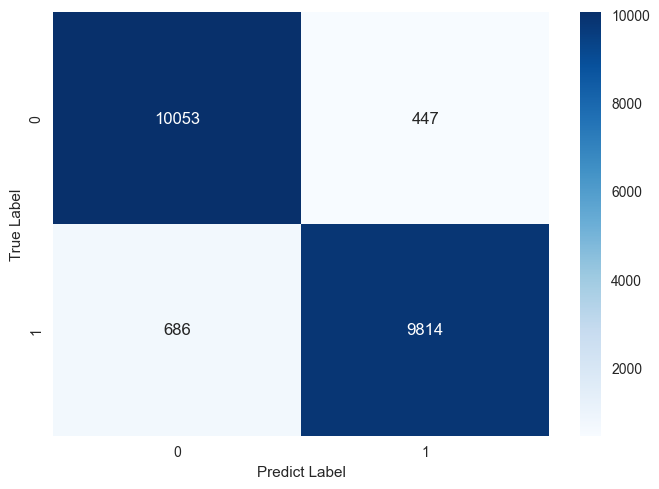


------------ROC AUC Curve---------------------


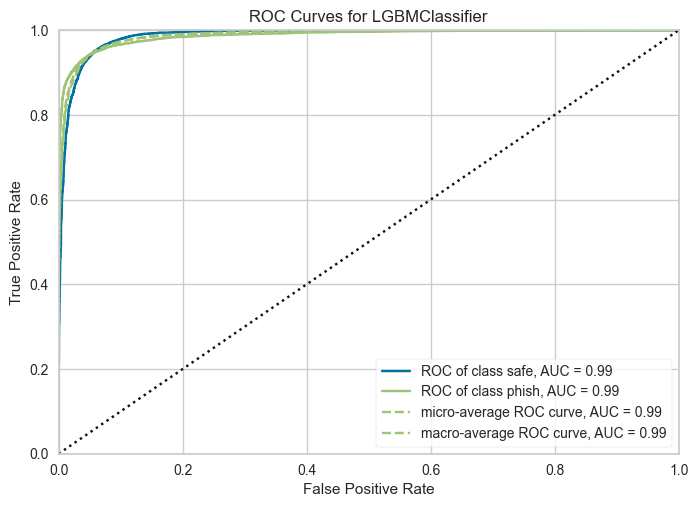

In [47]:
model1 = lgb.LGBMClassifier()
model1_result = model_training(model1, X_train, y_train, X_test, y_test)

In [15]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [25]:
#roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
#roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
#roc_auc_score(y, model.predict_proba(X_selected)[:,1])

In [48]:
feature_importance_map = {}
importances = model.feature_importances_ 
for feature, importance in zip(features_selected, importances):
    feature_importance_map[feature] = (importance*100).round(2)

sorted_dict = {k: v for k, v in sorted(feature_importance_map.items(), key=lambda item: item[1] ,reverse=True)}
#sorted_dict

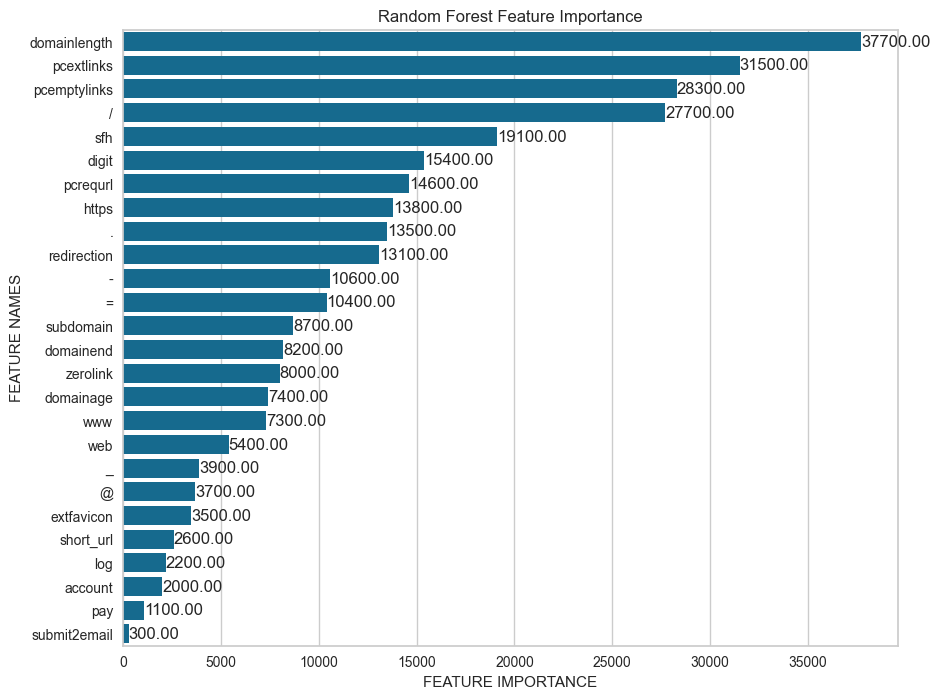

In [49]:
data={'feature_names':features_selected,'feature_importance':(model.feature_importances_*100).round(2)}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
barplot = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
plt.title('Random Forest Feature Importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
for bar in barplot.patches:
    # Get the x and y coordinates of the bar
    x = bar.get_x() + bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    
    # Add the text annotation to the bar
    barplot.text(x, y, f'{bar.get_width():.2f}', ha='left', va='center')

## Model 2 Hyperparameter tuning

In [28]:
cv = StratifiedKFold(3)
param_grid = {
  'learning_rate': [0.05, 0.005],
  'n_estimators': [400, 500, 600],
  'num_leaves': [31, 63, 100, 127],
  'boosting_type' : ['gbdt'],
  'max_depth': [-1, 10, 15, 20]
}

model_lgb = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=0)
grid_lgb = GridSearchCV(estimator=model_lgb, param_grid=param_grid, cv=cv,scoring='accuracy',refit=True,verbose=2)
grid_result_lgb =grid_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[LightGBM] [Info] Number of positive: 16333, number of negative: 16333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 32666, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=-1, n_estimators=400, num_leaves=31; total time=   0.5s
[LightGBM] [Info] Number of positive: 16334, number of negative: 16333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

In [29]:
print('Best Score: ', grid_result_lgb.best_score_)
print('Best Params: ', grid_result_lgb.best_params_)

Best Score:  0.9483673452298286
Best Params:  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 400, 'num_leaves': 127}


In [31]:
model2 = grid_lgb.best_estimator_

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

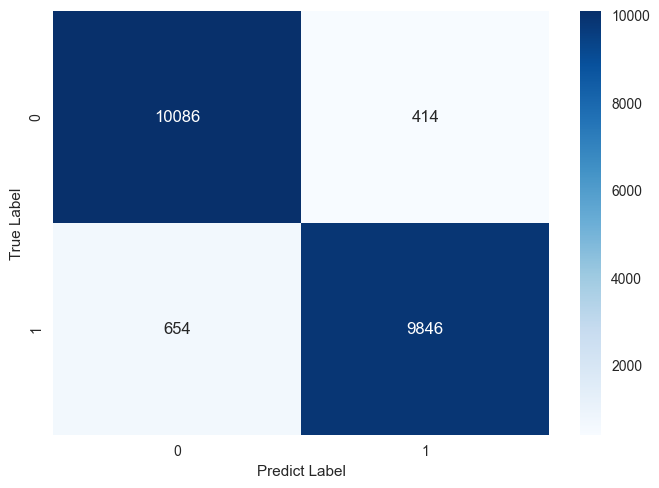


------------ROC AUC Curve---------------------


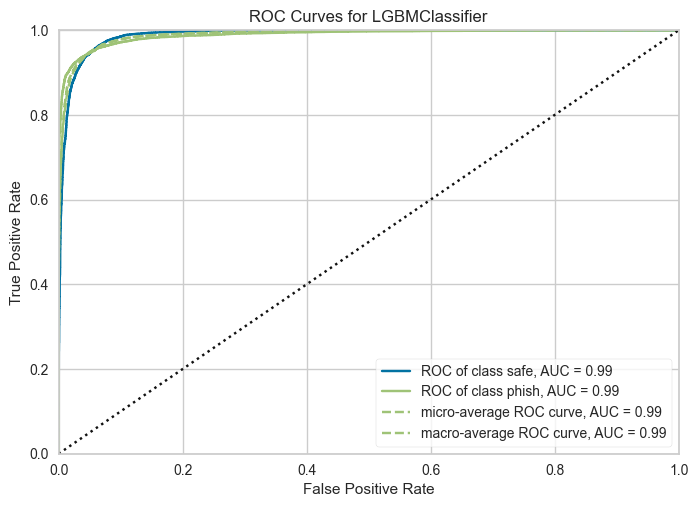

In [50]:
model2_result = model_training(model2, X_train, y_train, X_test, y_test)

In [66]:
model2_cvresult = kfoldcv(model2, X,y)

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [67]:
model2_result_df = pd.DataFrame(model2_result)
model2_result_df

,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"LGBMClassifier(learning_rate=0.05, max_depth=1...",2.691096,"[8971, 1359, 1226, 1540, 660, 124, 2140, 1290,...",0.949143,"{'0': {'precision': 0.9391061452513967, 'recal...","[[10086, 414], [654, 9846]]"


In [71]:
model2_result_df.to_csv('model_hyperparametised.csv', index =False)

In [68]:
model2_cvresult_df = pd.DataFrame(model2_cvresult)
model2_cvresult_df

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"LGBMClassifier(learning_rate=0.05, max_depth=1...",2.521537,0.13966,0.950657,0.959991,0.940514,0.950652


In [72]:
model2_result_df.to_csv('model_hyperparametised_cv.csv', index =False)

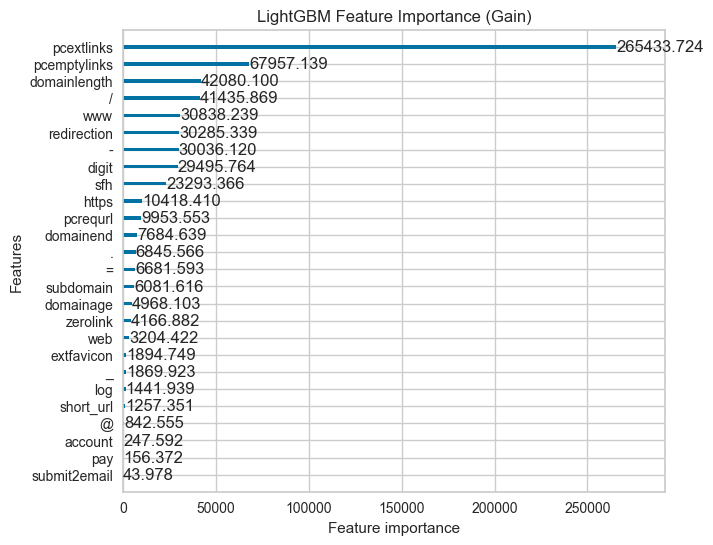

In [22]:
# Plot feature importance using Gain
lgb.plot_importance(model2, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [1]:
import pickle
import gzip
import joblib


def load_model(filename):
    with gzip.open(filename, 'rb') as f:
        model = pickle.load(f)
    return model


def load_joblib_model(filename):
    model = joblib.load(filename)
    return model

In [2]:
model = load_joblib_model("model.joblib")